In [ ]:
%matplotlib inline

# Assuming we are in the notebooks directory, we need to move one up:
%cd ..

from __future__ import division

import os
import us
import requests

import pandas as pd
import geopandas as gpd

from secret import *
from default_values import *

In [2]:
state = u'Virginia'
state_fips = us.states.lookup(state).fips
state_fips

u'51'

In [9]:
# try:
if True:
    print 'Attempting to load predicted population by block for:', state
#     df = gpd.read_file(blocks_geojson_filename)
# except IOError:
    print '\tNot found on disk...'
    print '\tDownloading and processing blocks and block groups for:', state
    # Open 2010 blocks for state (the population):
    print '\tOpening 2010 blocks shapefile for:', state
    blocks_2010_shapefile_name = blocks_2010_shapefile_dir + 'tabblock2010_' +\
        state_fips + '_pophu.shp'
    blocks_df = gpd.read_file(blocks_2010_shapefile_name)
    blocks_df['BLOCKID10'] = blocks_df['BLOCKID10'].apply(str)
    def get_group_GEOID(blockGEOID):
        return blockGEOID[0:-3]
    blocks_df['Block Group GEOID'] = blocks_df['BLOCKID10'].apply(get_group_GEOID)
    assert (blocks_df['Block Group GEOID'].apply(len)).unique() == [12]
    # The filename for the whole state with block groups (without population):
    print '\tOpening ACS5 block groups shapefile for:', state
    block_groups_shapefile_name = acs5_shapefile_dir + 'tl_' + year + '_' +\
        state_fips + '_bg.shp'
    block_groups_df = gpd.read_file(block_groups_shapefile_name)
    # We will add to this the population per block group from the API.
    # Check GEOIDs are of length 12 because they have to be by definition,
    # see: https://www.census.gov/geo/reference/geoidentifiers.html
    assert (block_groups_df['GEOID'].apply(len)).unique() == [12]

    
    
    
    print set(block_groups_df['GEOID'].unique()).symmetric_difference(set(
        blocks_df['Block Group GEOID'].unique()))
        # ['060378002043', '060379304011', u'060371370002', u'060371370001']

Attempting to load predicted population by block for: Virginia
	Not found on disk...
	Opening 2010 blocks shapefile for: Virginia
	Opening ACS5 block groups shapefile for: Virginia
set([u'510190501004', u'510190501005', u'510190501001', u'510190501002', u'510190501003', '515150501003', '515150501002', '515150501001', '515150501005', '515150501004'])


In [10]:
diff = list(set(block_groups_df['GEOID'].unique()).symmetric_difference(set(
         blocks_df['Block Group GEOID'].unique())))
len(diff)

10

In [11]:
for d in diff:
    if d in blocks_df['Block Group GEOID'].values:
        print d

515150501003
515150501002
515150501001
515150501005
515150501004


In [12]:
# del lost_block_groups
#These are the block groups that get lost:
for i, d in enumerate(diff):
#     print i
#     d = str(d)
#     print block_groups_df[block_groups_df['GEOID'].astype(str).str.contains(d)]
    try:
        lost_block_groups = pd.concat([lost_block_groups,
                                      block_groups_df[block_groups_df['GEOID'].astype(str).str.contains(d)]])
    except NameError:
        lost_block_groups = block_groups_df[block_groups_df['GEOID'].astype(str).str.contains(d)]
lost_block_groups.shape

(5, 13)

In [13]:
lost_block_groups

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry
2825,5153425,4049,4,019,S,510190501004,+37.3305215,-079.5359620,G5030,Block Group 4,51,050100,"POLYGON ((-79.55945299999999 37.33933, -79.559..."
2826,3834614,34866,5,019,S,510190501005,+37.3306886,-079.5069523,G5030,Block Group 5,51,050100,"POLYGON ((-79.52344599999999 37.334641, -79.52..."
2827,2881842,8160,1,019,S,510190501001,+37.3426350,-079.5064689,G5030,Block Group 1,51,050100,"POLYGON ((-79.52292 37.33595, -79.522815999999..."
2823,3537683,6596,2,019,S,510190501002,+37.3485833,-079.5168720,G5030,Block Group 2,51,050100,POLYGON ((-79.53537299999999 37.35531599999999...
2824,2392596,7647,3,019,S,510190501003,+37.3452985,-079.5380822,G5030,Block Group 3,51,050100,"POLYGON ((-79.55565 37.344404, -79.555589 37.3..."


In [14]:
# block_groups_df.head()

In [15]:
# blocks_df.head()

In [16]:
# blocks_df.dissolve(by='STATEFP10').plot()

In [17]:
# block_groups_df.dissolve(by='STATEFP').plot()

In [18]:
#     for bg_index, bg_row in block_groups_df.iterrows():
#         for b_index, b_row in blocks_df.iterrows():
#             intersection_area = bg_row['geometry'].intersection(b_row['geometry']).area
#             if intersection_area > 0.00001:
#                 print intersection_area


In [19]:
    print len(set(block_groups_df['GEOID'].unique()).difference(set(
        blocks_df['Block Group GEOID'].unique())))


5


In [20]:
    print len(set(
         blocks_df['Block Group GEOID'].unique()).difference(set(block_groups_df['GEOID'].unique())))

5


In [21]:
    print blocks_df[blocks_df['Block Group GEOID'] == '040194705002']['POP10']


Series([], Name: POP10, dtype: int64)


In [22]:
    print blocks_df[blocks_df['Block Group GEOID'] == '060371370001']['POP10']

Series([], Name: POP10, dtype: int64)


In [23]:
        # Code to get the total estimated population from the census files:
        api_population = 'B01003_001E'  # http://api.census.gov/data/2015/acs5/variables.html
        # NB: this is not the same code in the shapefiles for each block from the 2010
        # census, which instead uses 'POP10'.
        # Get all the counties' IDs so we can d/l each county's population per
        # block group:
        def block_group_to_county_geoid(geoid):
            return geoid[2:5]
        block_groups_df['County'] = block_groups_df['GEOID'].apply(block_group_to_county_geoid)
        block_groups_for_state = acs5_population_dir + state + '.json'
        try:
            print '\tAttempting to load ACS5 population for block groups by county for:', state
            with open(block_groups_for_state, 'r') as infile:
                population_df = pd.read_json(infile)
        except IOError:
            print '\t\tNot found on disk...'
            counties = block_groups_df['County'].unique()
            for county in counties:
                print '\t\tDownloading block groups for county:', county
                url = 'http://api.census.gov/data/' + year + '/acs5?get=NAME,' +\
                    api_population + '&for=block+group:*&in=state:' + \
                    state_fips + '+county:' + county + '&key=' + apikey
                # Make a get request to get the population of each county per block
                # group:
                response = requests.get(url)
                try:
                    data = response.json()
                except ValueError:  # includes simplejson.decoder.JSONDecodeError
                    # This is what happens when the server times out etc.
                    print 'Decoding JSON has failed. Server response:',\
                        response.status_code
                    exit()
                # Merge the df to get one huge df for the whole state which contains
                # all the group blocks and their populations:
                columns = data.pop(0) # columns as list and leaves data intact
                try:
                    # Try appending to previous population_df:
                    population_df = population_df.append(
                        pd.DataFrame(data, columns=columns),
                        ignore_index=True)
                except NameError:
                    # There is no previous, so create it:
                    population_df = pd.DataFrame(data, columns=columns)
            population_df.to_json(block_groups_for_state)
        print '\tDone!'

	Attempting to load ACS5 population for block groups by county for: Virginia
		Not found on disk...
	Done!


In [24]:
    def create_geoid(row):
        # GEOID Structure is defined as STATE + COUNTY + TRACT + BLOCK GROUP =
        # 2 + 3 + 6 + 1 = 12
        # see: https://www.census.gov/geo/reference/geoidentifiers.html
        STATE = str(row['state']).zfill(2)  # zero padding to conform to GEOID
        COUNTY = str(row['county']).zfill(3)
        TRACT = str(row['tract']).zfill(6)
        BLOCK_GROUP = str(row['block group'])
        assert len(STATE + COUNTY + TRACT + BLOCK_GROUP) == 12
        return STATE + COUNTY + TRACT + BLOCK_GROUP
    population_df['GEOID'] = population_df.apply(create_geoid, axis=1)
    
    

In [25]:
block_groups_df.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry,County
0,17318797,29278,4,031,S,510310204034,+37.2893326,-079.2458681,G5030,Block Group 4,51,020403,"POLYGON ((-79.282174 37.246022, -79.282145 37....",031
1,63309955,824092,3,031,S,510310201013,+37.3760611,-079.0241906,G5030,Block Group 3,51,020101,"POLYGON ((-79.074242 37.355248, -79.0741939999...",031
2,33306034,296338,1,031,S,510310206001,+37.1391859,-079.2002246,G5030,Block Group 1,51,020600,"POLYGON ((-79.243837 37.123124, -79.243786 37....",031
3,6130330,25812,1,031,S,510310204011,+37.3318804,-079.2231051,G5030,Block Group 1,51,020401,"POLYGON ((-79.24656899999999 37.329217, -79.24...",031
4,1617719,1918,1,031,S,510310203001,+37.3438080,-079.2417715,G5030,Block Group 1,51,020300,"POLYGON ((-79.254682 37.34787499999999, -79.25...",031


In [26]:
    block_groups_df = block_groups_df.merge(population_df, on='GEOID')
    assert block_groups_df['GEOID'].shape == population_df['GEOID'].shape
#     del population_df
    # Get rid of other columns, we are just interested in below for each block
    # group:
    block_groups_df = block_groups_df.loc[:,['GEOID',api_population]]
    # We need to calculate the proportion of the populalion of 2010 block group
    # that a constituent 2010 block has:
    # a. get the total population for each block group from 2010 and associate
    # each 2010 block with its total:
    blocks_df['POP10'] = pd.to_numeric(blocks_df['POP10'])
    blocks_df = blocks_df.join(blocks_df.groupby('Block Group GEOID')[
                               'POP10'].sum(), on='Block Group GEOID',
                                rsuffix=' for 2010 Block Group')
    blocks_df.rename(columns={'POP10 for 2010 Block Group':\
                              'Population for 2010 Block Group'}, inplace=True)

In [27]:
blocks_df.head()

,BLOCKCE,BLOCKID10,COUNTYFP10,HOUSING10,PARTFLG,POP10,STATEFP10,TRACTCE10,geometry,Block Group GEOID,Population for 2010 Block Group
0,1093,510010902001093,001,3,N,6,51,090200,"POLYGON ((-75.53995399999999 37.953723, -75.54...",510010902001,867
1,2161,510010904002161,001,0,N,0,51,090400,"POLYGON ((-75.55210699999999 37.768716, -75.55...",510010904002,1487
2,3076,510010904003076,001,4,N,9,51,090400,"POLYGON ((-75.631759 37.752436, -75.632374 37....",510010904003,2036
3,2067,510010908002067,001,0,N,0,51,090800,"POLYGON ((-75.80591299999999 37.466697, -75.80...",510010908002,1598
4,2022,510010908002022,001,0,N,0,51,090800,"POLYGON ((-75.71920899999999 37.495485, -75.71...",510010908002,1598


In [28]:

# b. get the ratio of block population to respective block group
# population:
def calculate_ratio(row):
    try:
        return row['POP10'] / row['Population for 2010 Block Group']
    except:
        return row['Population for 2010 Block Group']
blocks_df['Population Ratio'] = blocks_df.apply(calculate_ratio, axis=1)
# c. get the population for the 2015 ACS5 block groups and associate them
# with their respective blocks:
blocks_df = pd.merge(blocks_df, block_groups_df,
                     left_on = 'Block Group GEOID',
                     right_on = 'GEOID')
blocks_df.rename(columns={api_population:\
                    'Population for ' + year + ' Block Group'},
                 inplace=True)
assert (blocks_df['GEOID'] == blocks_df['Block Group GEOID']).all()
del blocks_df['GEOID']
blocks_df['Population for ' + year + ' Block Group'] =\
    pd.to_numeric(blocks_df['Population for ' + year + ' Block Group'])
assert block_groups_df[api_population].sum() > blocks_df['POP10'].sum()
# assert blocks_df['Population for 2010 Block Group'].sum() <\
    # blocks_df['Population for ' + year + ' Block Group'].sum()
#     del block_groups_df # we do not need this anymore
# d. calculate the predicted population for the block based on the above:
blocks_df[population] = blocks_df['Population Ratio'] *\
    blocks_df['Population for ' + year + ' Block Group']
# Calculate the centroids for each block required for clustering:
def get_x(p): return p.x
def get_y(p): return p.y
blocks_df['Centroid Longitude'] = blocks_df['geometry'].centroid.apply(get_x)
blocks_df['Centroid Latitude'] = blocks_df['geometry'].centroid.apply(get_y)
# Find which congressional district each block group for this state belongs
#  to. This is done using the block assignments files downloaded from:
#  https://www.census.gov/geo/maps-data/data/baf.html
# print '\tCalculating congressional districts for:', state
block_assignments_df = pd.read_csv(block_assignments_dir +\
    'National_CD115.txt', dtype={"BLOCKID": str, "CD115": str})
block_assignments_df.rename(columns={'BLOCKID': 'GEOID'}, inplace=True)
blocks_df.rename(columns={'BLOCKID10': 'GEOID'}, inplace=True)
blocks_df = blocks_df.merge(block_assignments_df, how='left',
    indicator=True)
assert blocks_df['_merge'].unique() == ['both']
del blocks_df['_merge']
del block_assignments_df
# We are done now, check that columns are what we expect before we remove
# useless ones:
assert list(blocks_df) ==\
    [u'BLOCKCE', 'GEOID', u'COUNTYFP10', u'HOUSING10', u'PARTFLG', u'POP10',
     u'STATEFP10', u'TRACTCE10', 'geometry', 'Block Group GEOID',
     'Population for 2010 Block Group', 'Population Ratio',
     'Population for 2015 Block Group', 'Predicted 2015 Population',
     'Centroid Longitude', 'Centroid Latitude', 'CD115']


In [29]:
blocks_df.head()

,BLOCKCE,GEOID,COUNTYFP10,HOUSING10,PARTFLG,POP10,STATEFP10,TRACTCE10,geometry,Block Group GEOID,Population for 2010 Block Group,Population Ratio,Population for 2015 Block Group,Predicted 2015 Population,Centroid Longitude,Centroid Latitude,CD115
0,1093,510010902001093,001,3,N,6,51,090200,"POLYGON ((-75.53995399999999 37.953723, -75.54...",510010902001,867,0.006920,691,4.782007,-75.546774,37.954116,02
1,1013,510010902001013,001,0,N,0,51,090200,"POLYGON ((-75.532816 37.988859, -75.5329529999...",510010902001,867,0.000000,691,0.000000,-75.533408,37.989547,02
2,1012,510010902001012,001,5,N,6,51,090200,"POLYGON ((-75.529713 37.984267, -75.5298449999...",510010902001,867,0.006920,691,4.782007,-75.530457,37.991878,02
3,1045,510010902001045,001,1,N,1,51,090200,"POLYGON ((-75.571759 37.989895, -75.5718679999...",510010902001,867,0.001153,691,0.797001,-75.576052,37.991432,02
4,1030,510010902001030,001,0,N,0,51,090200,"POLYGON ((-75.54496899999999 37.981008, -75.54...",510010902001,867,0.000000,691,0.000000,-75.545360,37.983905,02


In [30]:
lost_block_groups.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry
2825,5153425,4049,4,019,S,510190501004,+37.3305215,-079.5359620,G5030,Block Group 4,51,050100,"POLYGON ((-79.55945299999999 37.33933, -79.559..."
2826,3834614,34866,5,019,S,510190501005,+37.3306886,-079.5069523,G5030,Block Group 5,51,050100,"POLYGON ((-79.52344599999999 37.334641, -79.52..."
2827,2881842,8160,1,019,S,510190501001,+37.3426350,-079.5064689,G5030,Block Group 1,51,050100,"POLYGON ((-79.52292 37.33595, -79.522815999999..."
2823,3537683,6596,2,019,S,510190501002,+37.3485833,-079.5168720,G5030,Block Group 2,51,050100,POLYGON ((-79.53537299999999 37.35531599999999...
2824,2392596,7647,3,019,S,510190501003,+37.3452985,-079.5380822,G5030,Block Group 3,51,050100,"POLYGON ((-79.55565 37.344404, -79.555589 37.3..."


In [31]:

    # Get rid of colums we do not need:
blocks_df = blocks_df.loc[:,['GEOID', 'CD115', 'geometry',
                                 'Predicted 2015 Population',
                                 'Centroid Longitude', 'Centroid Latitude']]

In [32]:
blocks_df.head()

,GEOID,CD115,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,510010902001093,02,"POLYGON ((-75.53995399999999 37.953723, -75.54...",4.782007,-75.546774,37.954116
1,510010902001013,02,"POLYGON ((-75.532816 37.988859, -75.5329529999...",0.000000,-75.533408,37.989547
2,510010902001012,02,"POLYGON ((-75.529713 37.984267, -75.5298449999...",4.782007,-75.530457,37.991878
3,510010902001045,02,"POLYGON ((-75.571759 37.989895, -75.5718679999...",0.797001,-75.576052,37.991432
4,510010902001030,02,"POLYGON ((-75.54496899999999 37.981008, -75.54...",0.000000,-75.545360,37.983905


In [33]:

# Give columns better names:
blocks_df.rename(columns={'CD115': 'Congressional District',
                          'Centroid Longitude': 'Centroid Longitude',
                          'Centroid Latitude': 'Centroid Latitude'},
                  inplace=True)
blocks_df['Congressional District'] = blocks_df['Congressional District'].apply(str)
blocks_df['Centroid Longitude'] = blocks_df['Centroid Longitude'].apply(float)
blocks_df['Centroid Latitude'] = blocks_df['Centroid Latitude'].apply(float)
blocks_df['Predicted 2015 Population'] = blocks_df['Predicted 2015 Population'].apply(float)
# We are finally done, save the file!
print 'Saving file...'
blocks_df = gpd.GeoDataFrame(blocks_df)
with open(blocks_geojson_filename, 'w') as outfile:
    outfile.write(blocks_df.to_json())
# In the rest of this code the block-wise dataframe with predicted
# populations is called just df:
df = blocks_df
del blocks_df
print 'Done!'

Saving file...
Done!


In [34]:
# del lost_block_groups['ALAND']
# del lost_block_groups['AWATER']
# del lost_block_groups['BLKGRPCE']

population_df.head()
lost_block_groups = lost_block_groups.merge(population_df, on='GEOID')

In [35]:
lost_block_groups.head()
lost_block_groups['Centroid Longitude'] = lost_block_groups['geometry'].centroid.apply(get_x)
    
lost_block_groups['Centroid Latitude'] = lost_block_groups['geometry'].centroid.apply(get_y)

In [36]:
lost_block_groups.rename(columns={'B01003_001E': 'Predicted 2015 Population'}, inplace=True)

lost_block_groups = lost_block_groups[['GEOID', 'geometry', 'Predicted 2015 Population', 'Centroid Longitude', 'Centroid Latitude']]
lost_block_groups.head()


,GEOID,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,510190501004,"POLYGON ((-79.55945299999999 37.33933, -79.559...",2216,-79.535365,37.330213
1,510190501005,"POLYGON ((-79.52344599999999 37.334641, -79.52...",1198,-79.506286,37.329718
2,510190501001,"POLYGON ((-79.52292 37.33595, -79.522815999999...",853,-79.503950,37.342783
3,510190501002,POLYGON ((-79.53537299999999 37.35531599999999...,1295,-79.516659,37.349142
4,510190501003,"POLYGON ((-79.55565 37.344404, -79.555589 37.3...",650,-79.535087,37.344807


In [37]:
df.tail()

,GEOID,Congressional District,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
285510,518400001002003,10,"POLYGON ((-78.158661 39.191404, -78.1592579999...",47.586207,-78.158163,39.191682
285511,518400001002005,10,"POLYGON ((-78.157359 39.188891, -78.157039 39....",63.448276,-78.156567,39.189882
285512,518400001002013,10,"POLYGON ((-78.1563 39.189602, -78.156224999999...",216.781609,-78.155209,39.190629
285513,518400001002006,10,"POLYGON ((-78.157912 39.191235, -78.156976 39....",37.011494,-78.157272,39.190543
285514,518400001002004,10,"POLYGON ((-78.159043 39.193009, -78.158164 39....",334.160920,-78.155957,39.193046


In [38]:
block_groups_df.head()

,GEOID,B01003_001E
0,510310204034,916
1,510310201013,2390
2,510310206001,1037
3,510310204011,3504
4,510310203001,960


In [39]:
# ['060378002043', '060379304011', u'060371370002', u'060371370001']

In [40]:
# def check_geoid(row):
#     if row['GEOID'] in '060379304011':
        
#         print row[['GEOID']]
        
#     else:
        
#         return
# df.apply(check_geoid,axis=1)

In [41]:
by_distrct_df = df.dissolve(by='Congressional District')

In [42]:
by_district_df = by_distrct_df
by_district_df

,geometry,GEOID,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
Congressional District,,,,,
01,"POLYGON ((-76.67525599999999 37.368573, -76.67...",510330302021190,0.000000,-77.151323,38.019560
02,"POLYGON ((-76.06945399999999 36.69385, -76.072...",510010902001093,4.782007,-75.546774,37.954116
03,"POLYGON ((-76.442886 36.81666999999999, -76.44...",510932802001074,8.213287,-76.781543,36.911686
04,"POLYGON ((-76.22984599999999 36.550552, -76.23...",510366003001004,2.413379,-77.049013,37.384408
05,"POLYGON ((-80.010273 36.795538, -80.0118959999...",510030112012084,3.016496,-78.751882,38.010169
06,"POLYGON ((-80.05133099999999 37.40392, -80.051...",510090101004197,2.418407,-79.318062,37.596633
07,"POLYGON ((-77.424306 37.417489, -77.4270779999...",510079302004059,17.720139,-77.778230,37.253752
08,"POLYGON ((-77.226432 38.630415, -77.226266 38....",510131001003018,39.346290,-77.144930,38.895366
09,"POLYGON ((-79.76991799999999 36.728387, -79.76...",510050802012111,0.000000,-79.966269,37.774511


In [43]:
usa = gpd.read_file(usa_shapefile_path)
cong_dist = usa[usa['STATEFP'].apply(
    int) == int(state_fips)]
del usa


In [44]:
cong_dist.head()

,ALAND,AWATER,CD115FP,CDSESSN,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,MTFCC,NAMELSAD,STATEFP,geometry
46,10909582912,1767244527,01,115,N,5101,+37.8807201,-076.9762880,C2,G5200,Congressional District 1,51,"POLYGON ((-77.81356799999999 38.530129, -77.81..."
89,2859165075,5175276563,02,115,N,5102,+37.3937297,-075.9356016,C2,G5200,Congressional District 2,51,"POLYGON ((-76.79773999999999 37.214087, -76.79..."
127,1618703360,406602884,03,115,N,5103,+36.9137548,-076.5694796,C2,G5200,Congressional District 3,51,"POLYGON ((-76.96941 36.696297, -76.96933299999..."
163,9432206964,297489515,04,115,N,5104,+36.9617490,-077.1577179,C2,G5200,Congressional District 4,51,"POLYGON ((-77.90025399999999 37.143885, -77.89..."
192,25977255356,391593341,05,115,N,5105,+37.3323415,-078.7235580,C2,G5200,Congressional District 5,51,"POLYGON ((-80.235294 36.87226, -80.231988 36.8..."


In [45]:
missing_bg_cong_dist = pd.DataFrame(columns=[['GEOID', 'Congressional District']])
missing_bg_cong_dist.head()

,GEOID,Congressional District


In [46]:
geoid = []
cd = []
for bg_index, bg_row in lost_block_groups.iterrows():
    for dist_index, dist_row in cong_dist.iterrows():
        bg_area =  bg_row['geometry'].area
        intersection_area = bg_row['geometry'].intersection(dist_row['geometry']).area
        if bg_area - intersection_area < 1e-10:
#             print bg_index, dist_row['CD115FP']
#             print intersection_area, bg_area
            geoid.append(bg_row['GEOID'])
            cd.append(dist_row['CD115FP'])
        
geoid, cd

([u'510190501004',
  u'510190501005',
  u'510190501001',
  u'510190501002',
  u'510190501003'],
 [u'05', u'05', u'05', u'05', u'05'])

In [47]:
missing_bg_cong_dist['GEOID'] = geoid
missing_bg_cong_dist['Congressional District'] = cd
missing_bg_cong_dist.head()

,GEOID,Congressional District
0,510190501004,05
1,510190501005,05
2,510190501001,05
3,510190501002,05
4,510190501003,05


In [48]:
lost_block_groups = lost_block_groups.merge(missing_bg_cong_dist, on = 'GEOID')
# del lost_block_groups['Congressional District_x']
# del lost_block_groups['Congressional District_y']

In [49]:
lost_block_groups.tail()


,GEOID,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude,Congressional District
0,510190501004,"POLYGON ((-79.55945299999999 37.33933, -79.559...",2216,-79.535365,37.330213,05
1,510190501005,"POLYGON ((-79.52344599999999 37.334641, -79.52...",1198,-79.506286,37.329718,05
2,510190501001,"POLYGON ((-79.52292 37.33595, -79.522815999999...",853,-79.503950,37.342783,05
3,510190501002,POLYGON ((-79.53537299999999 37.35531599999999...,1295,-79.516659,37.349142,05
4,510190501003,"POLYGON ((-79.55565 37.344404, -79.555589 37.3...",650,-79.535087,37.344807,05


In [50]:
df.head()

,GEOID,Congressional District,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,510010902001093,02,"POLYGON ((-75.53995399999999 37.953723, -75.54...",4.782007,-75.546774,37.954116
1,510010902001013,02,"POLYGON ((-75.532816 37.988859, -75.5329529999...",0.000000,-75.533408,37.989547
2,510010902001012,02,"POLYGON ((-75.529713 37.984267, -75.5298449999...",4.782007,-75.530457,37.991878
3,510010902001045,02,"POLYGON ((-75.571759 37.989895, -75.5718679999...",0.797001,-75.576052,37.991432
4,510010902001030,02,"POLYGON ((-75.54496899999999 37.981008, -75.54...",0.000000,-75.545360,37.983905


In [51]:
df.shape
df = df.append(lost_block_groups, ignore_index=True)
df.shape

(285520, 6)

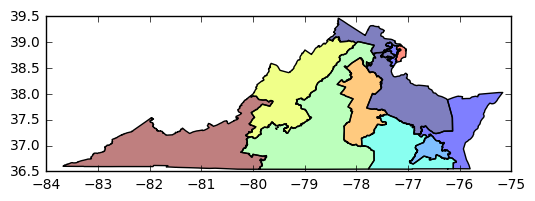

In [52]:
df.dissolve(by='Congressional District').plot()